In [1]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import plotnine
from plotnine import *

In [2]:
# 경로 설정
data_path = '../../data'
saved_path = './../saved'
output_path = '.././submission'

# 데이터 불러오기
start_df = pd.read_csv(os.path.join(data_path, 'history_data.csv'), encoding='utf-8')
end_df = pd.read_csv(os.path.join(data_path, 'watch_e_data.csv'), encoding='utf-8')
buy_df = pd.read_csv(os.path.join(data_path, 'buy_data.csv'), encoding='utf-8')
search_df = pd.read_csv(os.path.join(data_path, 'search_data.csv'), encoding='utf-8')

meta_df = pd.read_csv(os.path.join(data_path, 'meta_data.csv'), encoding='utf-8')
meta_plus_df = pd.read_csv(os.path.join(data_path, 'meta_data_plus.csv'), encoding='utf-8')

profile_df = pd.read_csv(os.path.join(data_path, 'profile_data.csv'), encoding='utf-8')

submission_df = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'), encoding='utf-8')

# start_df & end_df

In [3]:
start_df.rename(columns={'log_time':'start'}, inplace=True)
end_df.rename(columns={'log_time':'end'}, inplace=True)

In [4]:
tmp={}
for idx,row in end_df.iterrows():
    if (row['profile_id'], row['ss_id']) in tmp:
        tmp[row['profile_id'], row['ss_id']][row['album_id']]=row
    else:
        tmp[row['profile_id'], row['ss_id']]={row['album_id']:row}

In [5]:
#같은 album_id여도 total_time이 다른 경우 존재
end_df[end_df['album_id']==3]

,profile_id,ss_id,end,act_target_dtl,album_id,watch_time,total_time,continuous_play
6370,139,20220309100243,20220309151727,MKID049,3,124,124,1
8444,201,20220321122354,20220321123575,MKID049,3,731,731,1
8669,201,20220423120533,20220423121826,MKID049,3,731,731,1
10044,264,20220315090755,20220315093233,MKID049,3,124,126,1
17512,572,20220308113913,20220308114859,MKID049,3,2,124,0
...,...,...,...,...,...,...,...,...
879643,32323,20220319195215,20220319205738,MKID049,3,124,125,1
883279,32390,20220319165481,20220319171838,MKID049,3,2,124,0
883804,32390,20220403205912,20220403210138,MKID049,3,24,124,0
886414,32614,20220304101838,20220304185009,MKID049,3,15,124,0


In [70]:
start_df[start_df['album_id']==3]['short_trailer'].nunique()

2

같은 album이어도 short_trailer가 다른 경우 존재

In [6]:
end=[]
watch=[]
for idx,row in start_df.iterrows():
    if (row['profile_id'], row['ss_id']) in tmp:
        if row['album_id'] in tmp[row['profile_id'], row['ss_id']]:
            end.append(tmp[row['profile_id'], row['ss_id']][row['album_id']]['end'])
            ratio=(tmp[row['profile_id'], row['ss_id']][row['album_id']]['watch_time'])/(meta_df[meta_df['album_id']==row['album_id']]['run_time'][:1].item())
            watch.append(min(ratio, 1))
        else:
            end.append(-1)
            watch.append(-1)
    else:
        end.append(-2)
        watch.append(-2)

In [7]:
sum([int(i==-1) for i in end])

76277

In [8]:
sum([int(i==-2) for i in end])

32784

In [9]:
start_df[(start_df['profile_id']==5) & (start_df['ss_id']==20220319095622)]

,profile_id,ss_id,start,act_target_dtl,album_id,payment,continuous_play,short_trailer
195,5,20220319095622,20220319095638,MKID003,92,NaN,N,N
196,5,20220319095622,20220319101359,MKID003,174,NaN,N,N
197,5,20220319095622,20220320115616,MKID003,175,NaN,Y,N
198,5,20220319095622,20220320115625,MKID003,176,NaN,Y,N
199,5,20220319095622,20220320115700,MKID003,161,NaN,Y,N
200,5,20220319095622,20220320120204,MKID003,161,NaN,Y,N


In [10]:
end_df[(end_df['profile_id']==5) & (end_df['ss_id']==20220319095622)]

,profile_id,ss_id,end,act_target_dtl,album_id,watch_time,total_time,continuous_play
194,5,20220319095622,20220319101355,MKID049,92,1036,1207,1
195,5,20220319095622,20220319101420,MKID049,174,20,745,0
196,5,20220319095622,20220320115621,MKID049,175,5,718,2
197,5,20220319095622,20220320115644,MKID049,176,19,115,0
198,5,20220319095622,20220320120200,MKID049,161,299,301,1
199,5,20220319095622,20220320120611,MKID049,161,246,301,0


start_df와 end_df의 continuous_play가 어떤 차이인지 모르겠다.

In [11]:
start_df.drop('act_target_dtl',axis=1,inplace=True)
start_df['end']=end
start_df['watch_ratio']=watch

In [112]:
preprocess1=start_df[['profile_id', 'ss_id', 'album_id', 'start', 'end', 'watch_ratio', 'payment', 'continuous_play', 'short_trailer']]
preprocess1

,profile_id,ss_id,album_id,start,end,watch_ratio,payment,continuous_play,short_trailer
0,3,20220301115653,15,20220301115719,20220301115805,1.000000,NaN,Y,N
1,3,20220301115653,16,20220301115809,20220301115954,0.990476,NaN,Y,N
2,3,20220301115653,17,20220301115958,20220301120114,1.000000,NaN,Y,N
3,3,20220301115653,18,20220301120118,20220301120226,0.985294,NaN,Y,N
4,3,20220301115653,19,20220301120229,20220301120400,1.000000,NaN,Y,N
...,...,...,...,...,...,...,...,...,...
1005646,33032,20220427155091,381,20220427155668,20220427155694,1.000000,NaN,Y,N
1005647,33032,20220427155091,381,20220427155680,20220427155694,1.000000,NaN,Y,N
1005648,33032,20220427155839,125,20220427155810,20220427155826,0.019231,NaN,Y,N
1005649,33032,20220427155706,125,20220427155838,20220427155836,0.011538,NaN,Y,N


In [30]:
preprocess1.to_csv(saved_path+'history1.csv', index=False)

# meta_df

In [13]:
tmp_mp={}
for idx, row in meta_plus_df.iterrows():
    if row['keyword_name'] in tmp_mp:
        tmp_mp[row['keyword_name']].add(row['keyword_type'])
    else:
        tmp_mp[row['keyword_name']]={(row['keyword_type'])}

In [14]:
for key in tmp_mp:
    if len(tmp_mp[key])>1:
        print(key, tmp_mp[key])

사랑 {'05030901', '05090702'}
호기심 {'0509070a', '0507061f'}
봄 {'050b0204', '05030a03'}
교통기관 {'050c0407', '050b0202'}
초등학생 {'050a0131', '0508030f'}
운동 {'05090804', '05090905'}
성격 {'050c0802', '050c0e03'}
시간 {'050c0908', '050c0e1c'}
외모 {'050c0803', '050c0e02'}
동물 {'05080101', '050c0a01', '050c0e0d'}
색깔 {'05030703', '050c0905', '050c0e09'}
가족 {'05030801', '050c0e06'}
음악 {'05030704', '050c0d02'}
장난감 {'050c0e11', '0508080b'}
게임 {'05030b02', '050c0e17'}
여행 {'050c080a', '050c0e28', '05030303'}
취미 {'05030318', '050c0e1b'}
생활도구 {'050b0206', '050c0406'}
곤충 {'050c0e0e', '05080126'}
날씨 {'05030a07', '050c0e16'}
o {'050c1304', '050c1403'}
과일 {'05080705', '050c0e0b'}
미술 {'050c0d01', '05030701'}
식물 {'050c0a02', '05080117'}
모양 {'050c0906', '050c0e0f'}
음식 {'050c0e0a', '05080701'}
겨울 {'05030a06', '050b0201'}
눈 {'05030a0a', '050a010c'}
성교육 {'050a0123', '05070e0c'}
나라 {'05070501', '050c0e24'}
i {'050c1402', '050c1303'}
a {'050c1401', '050c1301'}
알레르기 {'050a010b', '05070e0a'}
우리나라 {'050c0408', '050b020a'}
쇼핑 {

동일 키워드, 다른 keyword_type

# buy_df

In [42]:
buy_df

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment
0,255,20220426153942,20220426154128,MKID004,3767,500
1,1603,20220309163919,20220309164043,MKID004,1640,300
2,5303,20220411080324,20220411082725,MKID004,3821,500
3,5303,20220411080324,20220411084013,MKID004,3822,500
4,5303,20220411080324,20220411085607,MKID004,3823,500
...,...,...,...,...,...,...
145,23882,20220421182514,20220421185231,MKID004,7441,300
146,23882,20220421182514,20220421185510,MKID004,8749,1200
147,31509,20220409115246,20220409115347,MKID004,19906,500
148,31837,20220427143436,20220427143618,MKID004,1640,300


In [57]:
payed=preprocess1[~ preprocess1['payment'].isna()]
payed[['profile_id','ss_id','payment']].drop_duplicates()

,profile_id,ss_id,payment
44,5,20220306110942,5040.0
110,5,20220309185728,5040.0
128,5,20220310180411,5040.0
204,5,20220321193733,5040.0
261,5,20220322183316,5040.0
...,...,...,...
1005529,33032,20220426115550,9900.0
1005530,33032,20220426115550,500.0
1005585,33032,20220427110951,14000.0
1005591,33032,20220427112116,14000.0


payment가 사용자가 특정 시점까지 총 지불한 금액인가?

In [53]:
len(set(preprocess1[~ preprocess1['payment'].isna()]['profile_id'])-set(buy_df.profile_id))

1675

In [54]:
len(set(buy_df.profile_id)-set(preprocess1[~ preprocess1['payment'].isna()]['profile_id']))

0

In [64]:
set(buy_df['album_id'])-set(preprocess1[~preprocess1['payment'].isna()]['album_id'])

{5274, 5771}

album_id 5274, 5771은 구매기록에 있지만 history_df에서는 구매하지 않은 것으로 표시

In [66]:
preprocess1[preprocess1['album_id']==5274]

,profile_id,ss_id,album_id,start,end,watch_ratio,payment,continuous_play,short_trailer
52875,1592,20220407165416,5274,20220407173058,20220407173100,0.003503,NaN,Y,Y
362452,8410,20220409202530,5274,20220409204030,-1,-1.000000,NaN,Y,Y
362453,8410,20220410210551,5274,20220410210559,20220410211530,0.998249,NaN,Y,N
687415,18019,20220320121549,5274,20220320123812,20220320124742,0.996497,NaN,Y,N
856450,23718,20220317153613,5274,20220317161048,20220317161735,0.711033,NaN,Y,N
941577,30737,20220325182222,5274,20220325183355,20220325183355,0.000000,NaN,Y,Y
941599,30737,20220328154045,5274,20220328162546,20220328162610,0.007005,NaN,Y,Y


In [71]:
preprocess1[preprocess1['album_id']==5771]

,profile_id,ss_id,album_id,start,end,watch_ratio,payment,continuous_play,short_trailer
432214,10416,20220404212633,5771,20220404212642,20220404212651,0.010624,NaN,Y,N


In [67]:
meta_df[meta_df['album_id']==5274]

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
23485,5274,페드로의 감기 외(영어),페파피그3(영어),키즈,외국어,영어,영국,571,NaN,페파,엄마,아빠,페드로,불곰,NaN,NaN


In [72]:
meta_df[meta_df['album_id']==5771]

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
17912,5771,장수풍뎅이 유인채집 외,에그박사 1 Part1,애니,MCN,NaN,한국,753,NaN,에그박사,NaN,NaN,NaN,NaN,NaN,NaN


# search_df

In [77]:
search_df=search_df.drop_duplicates()
search_df

,profile_id,ss_id,log_time,act_target_dtl,album_id
0,59,20220303183951,20220303183914,MKID017,2141
3,59,20220304181433,20220304181525,MKID017,512
4,59,20220304181433,20220304182447,MKID017,2141
5,59,20220312071555,20220312071637,MKID017,2142
6,59,20220312071555,20220312081857,MKID017,2142
...,...,...,...,...,...
6469,32965,20220423161110,20220423164503,MKID017,23083
6470,32965,20220424065420,20220424065456,MKID017,15080
6471,32965,20220425073255,20220425073358,MKID017,15080
6472,32965,20220427062749,20220427063353,MKID017,16497


In [109]:
preprocess1

,profile_id,ss_id,album_id,start,end,watch_ratio,payment,continuous_play,short_trailer
0,3,20220301115653,15,20220301115719,20220301115805,1.000000,NaN,Y,N
1,3,20220301115653,16,20220301115809,20220301115954,0.990476,NaN,Y,N
2,3,20220301115653,17,20220301115958,20220301120114,1.000000,NaN,Y,N
3,3,20220301115653,18,20220301120118,20220301120226,0.985294,NaN,Y,N
4,3,20220301115653,19,20220301120229,20220301120400,1.000000,NaN,Y,N
...,...,...,...,...,...,...,...,...,...
1005646,33032,20220427155091,381,20220427155668,20220427155694,1.000000,NaN,Y,N
1005647,33032,20220427155091,381,20220427155680,20220427155694,1.000000,NaN,Y,N
1005648,33032,20220427155839,125,20220427155810,20220427155826,0.019231,NaN,Y,N
1005649,33032,20220427155706,125,20220427155838,20220427155836,0.011538,NaN,Y,N


In [113]:
search2watch=[]
for idx,row in search_df.iterrows():
    if row['album_id'] in start_df[preprocess1['profile_id']==row['profile_id']]['album_id'].to_list():
        search2watch.append(preprocess1[(preprocess1['profile_id']==row['profile_id']) & (preprocess1['album_id']==row['album_id'])])

In [104]:
len(search2watch)

5734

In [105]:
search2watch[0]

,profile_id,ss_id,album_id,start,end,watch_ratio,payment,continuous_play,short_trailer
3280,59,20220303183951,2141,20220303183920,20220303183994,0.001961,NaN,N,N
3281,59,20220303183951,2141,20220303183920,20220303183994,0.001961,NaN,N,N
3282,59,20220303183951,2141,20220303183920,20220303183994,0.001961,NaN,N,N
3284,59,20220304181433,2141,20220304182451,20220304183320,0.998039,NaN,N,N


In [141]:
dataframe=pd.DataFrame()
for tmp in search2watch:
    dataframe=pd.concat([dataframe,tmp])

In [124]:
plt.rc('axes', unicode_minus=False)

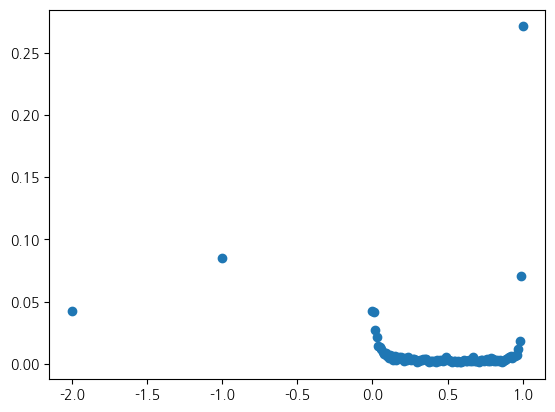

In [142]:
dataframe=dataframe.drop_duplicates()
dataframe['watch_ratio']=dataframe['watch_ratio'].apply(lambda x:round(x,2))
a = dataframe['watch_ratio'].value_counts()/len(dataframe)
plt.scatter(a.index,a)
plt.show()

# profile_df

In [15]:
profile_df

,profile_id,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3
0,3,F,5,P02,P04,P07,K01,K03,K04
1,5,M,5,P07,P08,P06,K05,K08,K09
2,7,F,9,P05,P03,NaN,K06,K04,NaN
3,12,M,6,P03,P06,P02,K09,K07,K03
4,16,F,12,P03,P06,P01,K01,K06,K04
...,...,...,...,...,...,...,...,...,...
8306,33022,M,1,P04,NaN,NaN,K04,K08,NaN
8307,33023,M,5,P06,P03,P07,K08,K04,K05
8308,33026,F,8,P01,P03,P08,K05,K09,K06
8309,33027,F,4,P04,P05,P06,K03,K01,K05


In [16]:
p_code={'P01':'과학기술','P02':'정서/사회성','P03':'자연탐구','P04':'바른생활/안전','P05':'활동/운동','P06':'음악예술','P07':'언어논리','P08':'수리논리'}
k_code={'K01':'노래/율동','K02':'동물/식물','K03':'동화','K04':'만들기','K05':'숫자/계산','K06':'외국어','K07':'친구/사람','K08':'탈 것/기계','K09':'활동/운동'}

In [17]:
profile_df['pr_interest_keyword_cd_1']=profile_df['pr_interest_keyword_cd_1'].apply(lambda x : p_code[x])
profile_df['pr_interest_keyword_cd_2']=profile_df['pr_interest_keyword_cd_2'].apply(lambda x : p_code[x] if not pd.isna(x) else x)
profile_df['pr_interest_keyword_cd_3']=profile_df['pr_interest_keyword_cd_3'].apply(lambda x : p_code[x] if not pd.isna(x) else x)
profile_df['ch_interest_keyword_cd_1']=profile_df['ch_interest_keyword_cd_1'].apply(lambda x : k_code[x])
profile_df['ch_interest_keyword_cd_2']=profile_df['ch_interest_keyword_cd_2'].apply(lambda x : k_code[x] if not pd.isna(x) else x)
profile_df['ch_interest_keyword_cd_3']=profile_df['ch_interest_keyword_cd_3'].apply(lambda x : k_code[x] if not pd.isna(x) else x)
profile_df

,profile_id,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3
0,3,F,5,정서/사회성,바른생활/안전,언어논리,노래/율동,동화,만들기
1,5,M,5,언어논리,수리논리,음악예술,숫자/계산,탈 것/기계,활동/운동
2,7,F,9,활동/운동,자연탐구,NaN,외국어,만들기,NaN
3,12,M,6,자연탐구,음악예술,정서/사회성,활동/운동,친구/사람,동화
4,16,F,12,자연탐구,음악예술,과학기술,노래/율동,외국어,만들기
...,...,...,...,...,...,...,...,...,...
8306,33022,M,1,바른생활/안전,NaN,NaN,만들기,탈 것/기계,NaN
8307,33023,M,5,음악예술,자연탐구,언어논리,탈 것/기계,만들기,숫자/계산
8308,33026,F,8,과학기술,자연탐구,수리논리,숫자/계산,활동/운동,외국어
8309,33027,F,4,바른생활/안전,활동/운동,음악예술,동화,노래/율동,숫자/계산


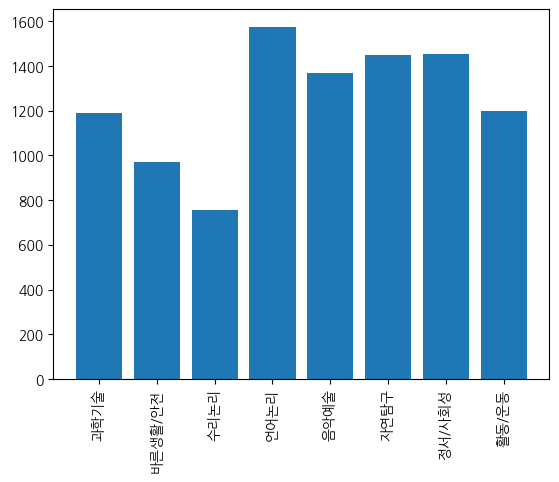

In [23]:
pr_M=profile_df[profile_df['sex']=='M'].pr_interest_keyword_cd_1.value_counts()+profile_df[profile_df['sex']=='M'].pr_interest_keyword_cd_2.value_counts()+profile_df[profile_df['sex']=='M'].pr_interest_keyword_cd_3.value_counts()
plt.bar(pr_M.index,pr_M)
plt.xticks(rotation=90)
plt.show()

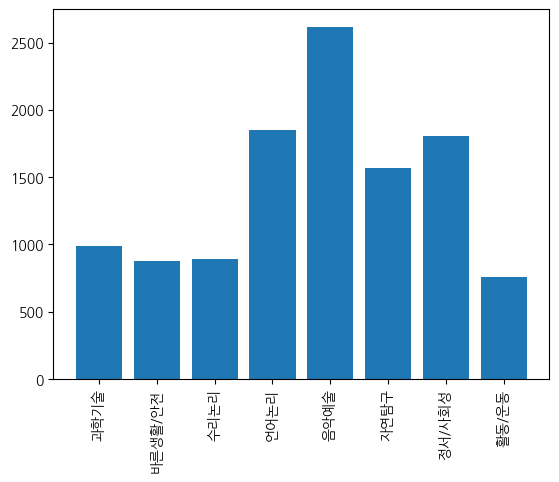

In [25]:
pr_F=profile_df[profile_df['sex']=='F'].pr_interest_keyword_cd_1.value_counts()+profile_df[profile_df['sex']=='F'].pr_interest_keyword_cd_2.value_counts()+profile_df[profile_df['sex']=='F'].pr_interest_keyword_cd_3.value_counts()
plt.bar(pr_F.index,pr_F)
plt.xticks(rotation=90)
plt.show()

성별에 따른 부모 관심 키워드

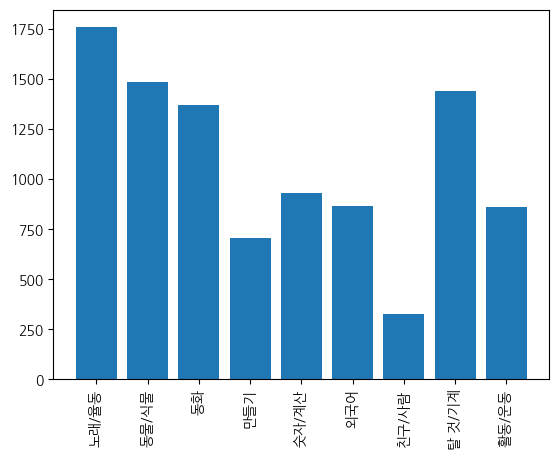

In [26]:
ch_M=profile_df[profile_df['sex']=='M'].ch_interest_keyword_cd_1.value_counts()+profile_df[profile_df['sex']=='M'].ch_interest_keyword_cd_2.value_counts()+profile_df[profile_df['sex']=='M'].ch_interest_keyword_cd_3.value_counts()
plt.bar(ch_M.index,ch_M)
plt.xticks(rotation=90)
plt.show()

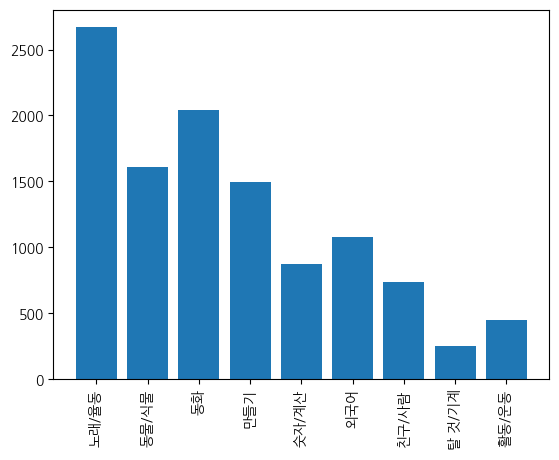

In [27]:
ch_F=profile_df[profile_df['sex']=='F'].ch_interest_keyword_cd_1.value_counts()+profile_df[profile_df['sex']=='F'].ch_interest_keyword_cd_2.value_counts()+profile_df[profile_df['sex']=='F'].ch_interest_keyword_cd_3.value_counts()
plt.bar(ch_F.index,ch_F)
plt.xticks(rotation=90)
plt.show()

성별에 따른 아이 관심 키워드